In [110]:
# Importing lib
import pandas as pd
import lightgbm as lgb
import numpy as np
import scipy.stats as stats
from sklearn.metrics import f1_score,roc_auc_score, average_precision_score
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from lightgbm import LGBMClassifier
import warnings
from sklearn import set_config
set_config(display='text')
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [162]:
#Loading Master Labelled Data and dropping potential data leak features
df_labeled=pd.read_csv("../Processed Data/prd_loyal_customers.csv")
df_labeled.drop(columns=['is_repeat_customer','days_since_last_order','is_first_order'], inplace=True)
df = df_labeled.copy()

FEATURE ENGINEERING FOR ENHANCED SIGNALS FOR ML MODELLING

To improve the model's ability to distinguish between repeat and non-repeat customers, I performed iterative feature engineering. By analyzing feature importance from multiple model runs, I developed a set of behavioral and economic signals. These features are designed to capture patterns in historical data for established repeaters while providing 'look-alike' signals to identify high-potential first-time customers

The definition of Metrics are:


1) sentiment_index: A numerical score capturing the customer’s satisfaction by weighting review scores against comment lengths or sentiment.

2) state_avg: The historical average order value for the customer's geographic region, representing local purchasing power.

3) cat_avg: The typical order value for a specific product category, used as a benchmark for "normal" spending behavior.

4) value_ratio: The ratio of a customer’s spend compared to the global average, identifying high-value vs. budget shoppers.

5) val_ratio_vs_category: Measures how much more (or less) a customer spent on a product compared to that category's typical price point.

6) freight_ordervalue_ratio: The percentage of the total cost spent on shipping, used to detect if high delivery fees deter repeat purchases.

7) price_spread_ratio: The variance between the highest and lowest-priced items in a single order, indicating "basket diversity."

8) order_value_spread_ratio: Measures the fluctuation in total spending across different orders to identify consistent vs. erratic spenders.

9) weight_spread_ratio: Captures the variation in physical weight of items ordered, distinguishing between bulk buyers and small-item shoppers.

10) volume_spread_ratio: Measures the variation in the physical dimensions (size) of items purchased to understand logistical complexity per customer.

In [163]:
score = df["avg_review_score"].fillna(-1)
length = df["avg_review_length"].fillna(0)
conditions = [
    (score >= 4) & (length > 0),                    # 5: Vocal Promoter
    (score >= 4) & (length == 0),                   # 4: Silent Satisfied
    (score == -1),                                  # 3: Ghost
    (score > 2) & (score < 4),                      # 2: Passive
    (score <= 2) & (score > 0) & (length == 0),     # 1: Quiet Detractor
    (score <= 2) & (score > 0) & (length > 0)       # 0: Vocal Detractor
]
choices = [5, 4, 3, 2, 1, 0]
df["sentiment_index"] = np.select(conditions, choices, default=3).astype(int)
df = df.drop(columns=["avg_review_length"], errors="ignore")

In [164]:
df = df_labeled.copy()
df["snapshot_date"] = pd.to_datetime(df["snapshot_date"], errors="coerce")
split_point = df["snapshot_date"].quantile(0.8)

train_idx = df["snapshot_date"] < split_point
test_idx  = df["snapshot_date"] >= split_point

In [165]:
df["main_category"] = df["main_category"].fillna("unknown").astype(str)

state_lookup = df.loc[train_idx].groupby("customer_state")["total_order_value"].mean()
cat_lookup   = df.loc[train_idx].groupby("main_category")["total_order_value"].mean()
global_avg   = df.loc[train_idx, "total_order_value"].mean()

df["state_avg"] = df["customer_state"].map(state_lookup).fillna(global_avg)
df["cat_avg"]   = df["main_category"].map(cat_lookup).fillna(global_avg)

df["value_ratio"]           = df["total_order_value"] / df["state_avg"]
df["val_ratio_vs_category"] = df["total_order_value"] / df["cat_avg"]
df["freight_ordervalue_ratio"] = df["total_freight_value"] / df["total_order_value"].replace(0, np.nan)

Instead of just having Min/Max as Features, it is better to take ratios of these features and derive new features. 

Reason: Tree Models like LightBGM, XGBoost etc, are better with ratios (for splits)

In [166]:
eps = 1e-6

df["price_spread_ratio"]      = df["max_price"] / (df["min_price"] + eps)
df["order_value_spread_ratio"]= df["max_order_value"] / (df["min_order_value"] + eps)

df["weight_spread_ratio"]     = df["max_weight"] / (df["avg_weight"] + eps)   
df["volume_spread_ratio"]     = df["max_volume"] / (df["avg_volume"] + eps)

In [167]:
for c in ["price_spread_ratio","order_value_spread_ratio","weight_spread_ratio","volume_spread_ratio"]:
    df[c] = df[c].clip(upper=50)  

In [168]:
# List of columns to drop
drop_cols = [
    'label_is_loyal','customer_id', 'order_id', 'customer_unique_id','order_purchase_timestamp', 'snapshot_date','past_order_count',        
    'customer_city','min_price', 'max_price','min_order_value', 'max_order_value','max_weight', 'max_volume', 'min_review_score', 'max_review_score', 
    'geolocation_lat', 'geolocation_lng', "is_latlng_missing","customer_state","customer_zip_code_prefix","total_freight_value","avg_freight_value",
    "total_order_value","state_avg","total_payment_value","tot_sellers_in_zip","tot_customers_in_zip","min_items","max_items"
]

X = df.drop(columns=drop_cols, errors='ignore')
y = df['label_is_loyal']

print(X.select_dtypes(include=['object']).columns)

Index(['main_category'], dtype='object')


TRAIN-TEST SPLIT BASED ON TIMELINE. --> Train on Historical Data and Test on New Data

In [169]:
# Splitting data based on Timeline i.e. Old Data for Training the Models and New Data For Testing the generalizale ability

df["snapshot_date"] = pd.to_datetime(df_labeled["snapshot_date"], errors="coerce")
df = df.sort_values("snapshot_date").copy()

test_cutoff = df["snapshot_date"].quantile(0.8)
val_cutoff = df["snapshot_date"].quantile(0.6)

train_idx = df["snapshot_date"] < val_cutoff
val_idx   = (df["snapshot_date"] >= val_cutoff) & (df["snapshot_date"] < test_cutoff)
test_idx  = df["snapshot_date"] >= test_cutoff

X_train, y_train = X[train_idx].copy(), y[train_idx].copy()
X_val,   y_val   = X[val_idx].copy(),   y[val_idx].copy()
X_test,  y_test  = X[test_idx].copy(),  y[test_idx].copy()

print(f"Training Range: {df.loc[train_idx, 'snapshot_date'].min()} to {df.loc[train_idx, 'snapshot_date'].max()}")
print(f"Test Range:     {df.loc[test_idx, 'snapshot_date'].min()} to {df.loc[test_idx, 'snapshot_date'].max()}")

Training Range: 2016-09-03 21:15:19 to 2018-03-01 13:34:44
Test Range:     2018-05-23 18:04:31 to 2018-08-28 15:00:37


MAIN CATEGORY: This categorical feature was transformed using Target Encoding with a smoothing factor to represent each product category by its historical conversion probability, effectively capturing the "loyalty potential" inherent to different product types.

In [170]:
te = TargetEncoder(cols=["main_category"], smoothing=5)
X_train["main_category"] = te.fit_transform(X_train["main_category"], y_train)

X_val["main_category"] = te.transform(X_val["main_category"])
X_test["main_category"] = te.transform(X_test["main_category"])

X_train["main_category"] = X_train["main_category"].fillna(y_train.mean())
X_val["main_category"]   = X_val["main_category"].fillna(y_train.mean())
X_test["main_category"]  = X_test["main_category"].fillna(y_train.mean())

In [26]:
print("Loyalty score for top categories in Train:")
print(X_train["main_category"].value_counts().head())

Loyalty score for top categories in Train:
main_category
0.061299    5514
0.049468    4609
0.041834    4470
0.041250    3903
0.058486    3830
Name: count, dtype: int64


<h2> LOGISTIC REGRESSION <h2>

### CORRELATION MATRIX ###

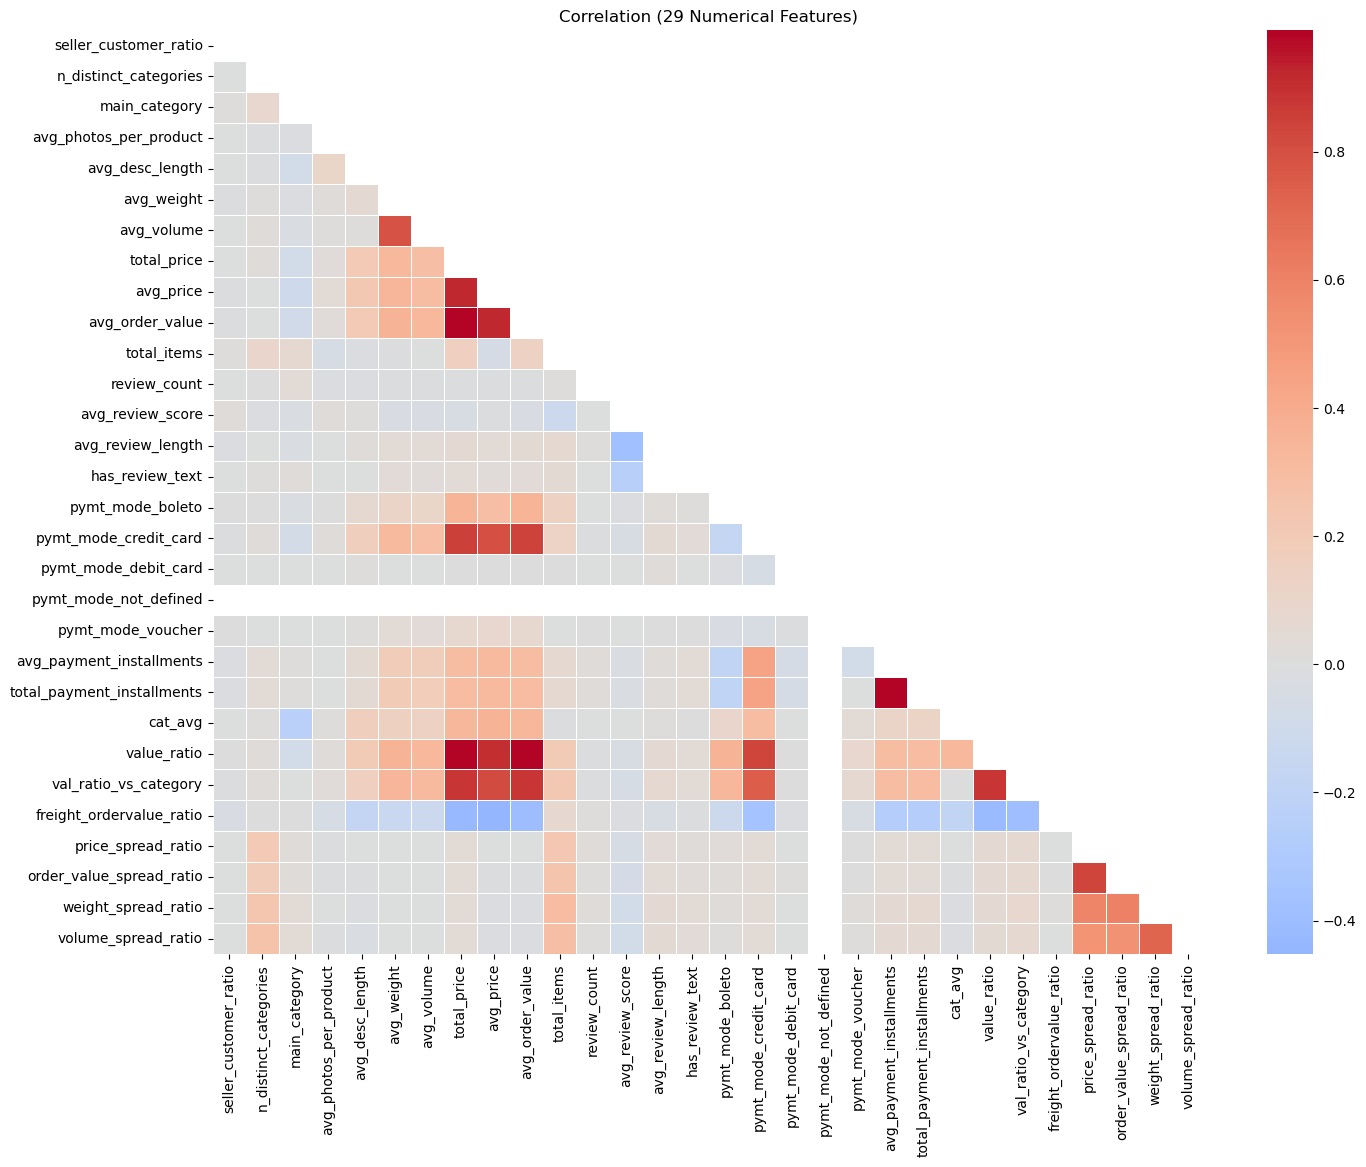

Highly Correlated Pairs (>0.8):
                        level_0                     level_1         0
211                 total_price                   avg_price  0.924239
212                 total_price             avg_order_value  0.989665
219                 total_price       pymt_mode_credit_card  0.851982
225                 total_price                 value_ratio  0.988223
226                 total_price       val_ratio_vs_category  0.885989
239                   avg_price                 total_price  0.924239
241                   avg_price             avg_order_value  0.923825
254                   avg_price                 value_ratio  0.905183
255                   avg_price       val_ratio_vs_category  0.814153
268             avg_order_value                 total_price  0.989665
269             avg_order_value                   avg_price  0.923825
277             avg_order_value       pymt_mode_credit_card  0.844941
283             avg_order_value                 value_rati

In [27]:
raw_corr = X_train.select_dtypes(include=['number']).corr()


plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(raw_corr, dtype=bool))

sns.heatmap(raw_corr, mask=mask, annot=False, cmap='coolwarm', center=0, linewidths=.5)
plt.title("Correlation (29 Numerical Features)")
plt.show()


high_corr = raw_corr.stack().reset_index()
high_corr = high_corr[high_corr[0].between(0.8, 0.999)] # Filter for high correlation but not self-correlation
print("Highly Correlated Pairs (>0.8):")
print(high_corr)

In [160]:
# List of redundant features identified in the Correlation Analysis
cols_to_drop = [
    'avg_price',               
    'avg_order_value',         
    'value_ratio',             
    'val_ratio_vs_category',            
    'avg_payment_installments', 
    'order_value_spread_ratio',
    'total_items',
    'total_price'
]
# Dropping from all sets to maintain consistency
X_train = X_train.drop(columns=cols_to_drop)
X_test = X_test.drop(columns=cols_to_drop)
X_val = X_val.drop(columns=cols_to_drop)

print(f"Features removed: {len(cols_to_drop)}")
print(f"New Feature Count: {X_train.shape[1]}")

Features removed: 8
New Feature Count: 22


In [ ]:
X_train['has_review_text'] = X_train['has_review_text'].fillna(0)
X_test['has_review_text'] = X_test['has_review_text'].fillna(0)

cols_to_impute = [
    'n_distinct_categories',
    'avg_photos_per_product',
    'avg_desc_length',
    'avg_weight',
    'avg_volume',
    'review_count',
    'avg_review_score',
    'avg_review_length',
    'freight_ordervalue_ratio',
    'pymt_mode_boleto',
    'pymt_mode_credit_card',
    'pymt_mode_debit_card',
    'pymt_mode_not_defined',
    'pymt_mode_voucher',
    'total_payment_installments',
    'price_spread_ratio',
    'weight_spread_ratio',
    'volume_spread_ratio'
]

X_train[cols_to_impute] = X_train[cols_to_impute].fillna(
    X_train[cols_to_impute].median()
)

X_test[cols_to_impute] = X_test[cols_to_impute].fillna(
    X_train[cols_to_impute].median()
)

Fixing Skewness and Scaling of Features

In [ ]:
skew_limit = 1.0
skewed_feats = X_train.select_dtypes(include=['number']).skew()
log_cols = skewed_feats[abs(skewed_feats) > skew_limit].index.tolist()


log_indices = [X_train.columns.get_loc(c) for c in log_cols]


# We Impute (fill NaNs) -> Log Transform -> Standard Scale
preprocessor = ColumnTransformer(
    transformers=[
        ('log', FunctionTransformer(np.log1p), log_indices)
    ],
    remainder='passthrough' # Keep columns that didn't need log
)

lr_final_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), 
    ('prep', preprocessor),
    ('scaler', StandardScaler()), 
    ('model', LogisticRegression(class_weight='balanced', solver='liblinear'))
])

### HYPERPARAM SELECTION USING GRIDSEARCHCV ###

In [ ]:
param_grid = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
}

grid_classifier = GridSearchCV(
    lr_final_pipe, 
    param_grid, 
    cv=5, 
    scoring='average_precision',
    n_jobs=-1 
)

grid_classifier.fit(X_train, y_train)
print(f"Best C value: {grid_classifier.best_params_['model__C']}")

Best C value: 0.01


In [122]:
lr_final_pipe.set_params(model__C=0.01)
lr_final_pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('log',
                                                  FunctionTransformer(func=<ufunc 'log1p'>),
                                                  [0, 1, 3, 4, 5, 6, 7, 8, 9,
                                                   11, 12, 13, 15, 16, 17, 18,
                                                   19, 20, 21])])),
                ('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    solver='liblinear'))])

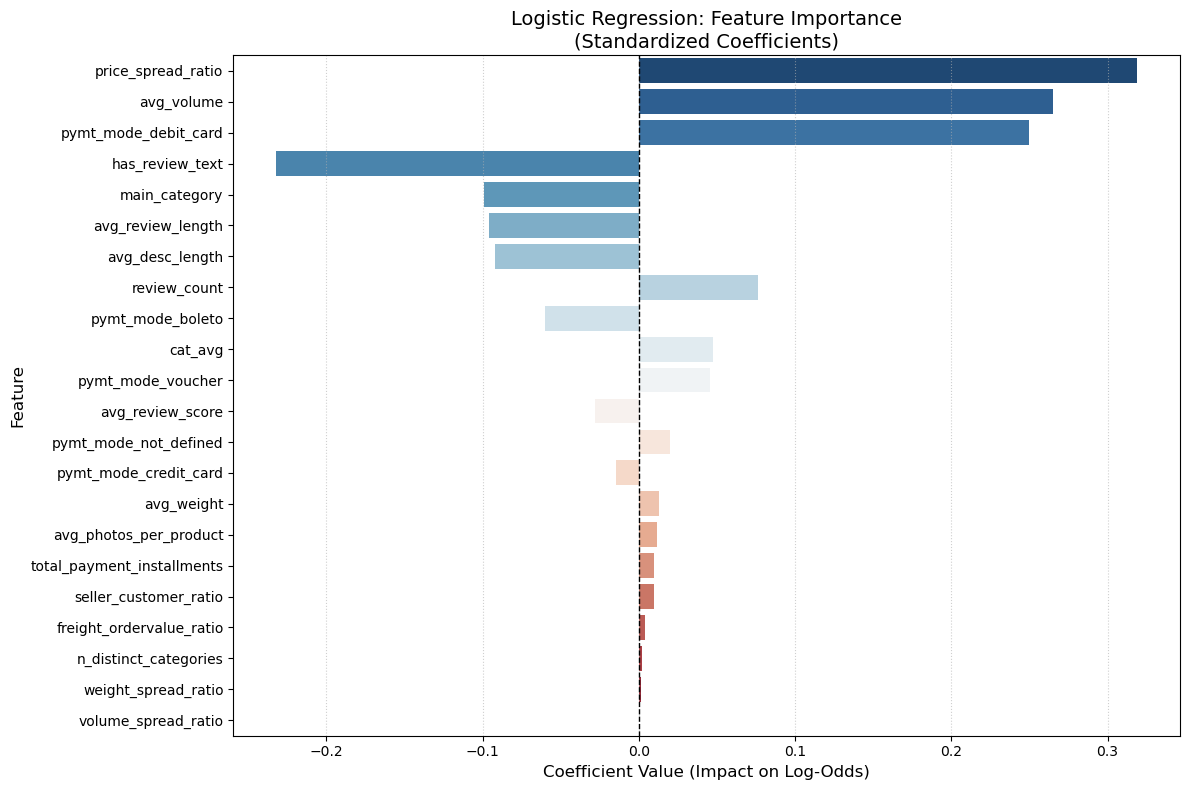

In [173]:
lr_model = lr_final_pipe.named_steps['model']
feature_names = X_train.columns


importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_model.coef_[0]
})


importance_df['Abs_Weight'] = importance_df['Coefficient'].abs()
importance_df = importance_df.sort_values(by='Abs_Weight', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(
    data=importance_df, 
    x='Coefficient', 
    y='Feature', 
    palette='RdBu_r',  
    hue='Feature',     
    legend=False
)


plt.title("Logistic Regression: Feature Importance\n(Standardized Coefficients)", fontsize=14)
plt.xlabel("Coefficient Value (Impact on Log-Odds)", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.axvline(0, color='black', linestyle='--', linewidth=1) # Center line
plt.grid(axis='x', linestyle=':', alpha=0.6)
plt.tight_layout()

plt.show()

In [123]:
y_pred = lr_final_pipe.predict(X_test)
y_proba = lr_final_pipe.predict_proba(X_test)[:, 1]

<Figure size 600x500 with 0 Axes>

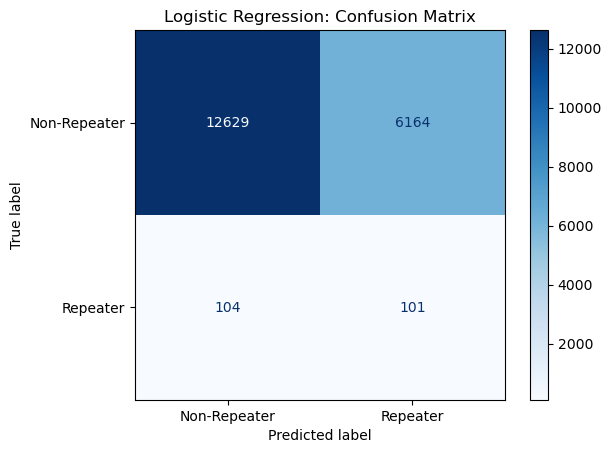

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Repeater', 'Repeater'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Logistic Regression: Confusion Matrix")
plt.show()

Our baseline model successfully identifies 50% of all repeat customers (Recall). However, because repeaters are so rare in our data, for every 1 true repeater we find, we currently target about 58 non-repeaters. This is a great starting point for a baseline, but it's why we are moving toward XGBoost and LightGBM to see if we can reduce those 5,969 false alarms."

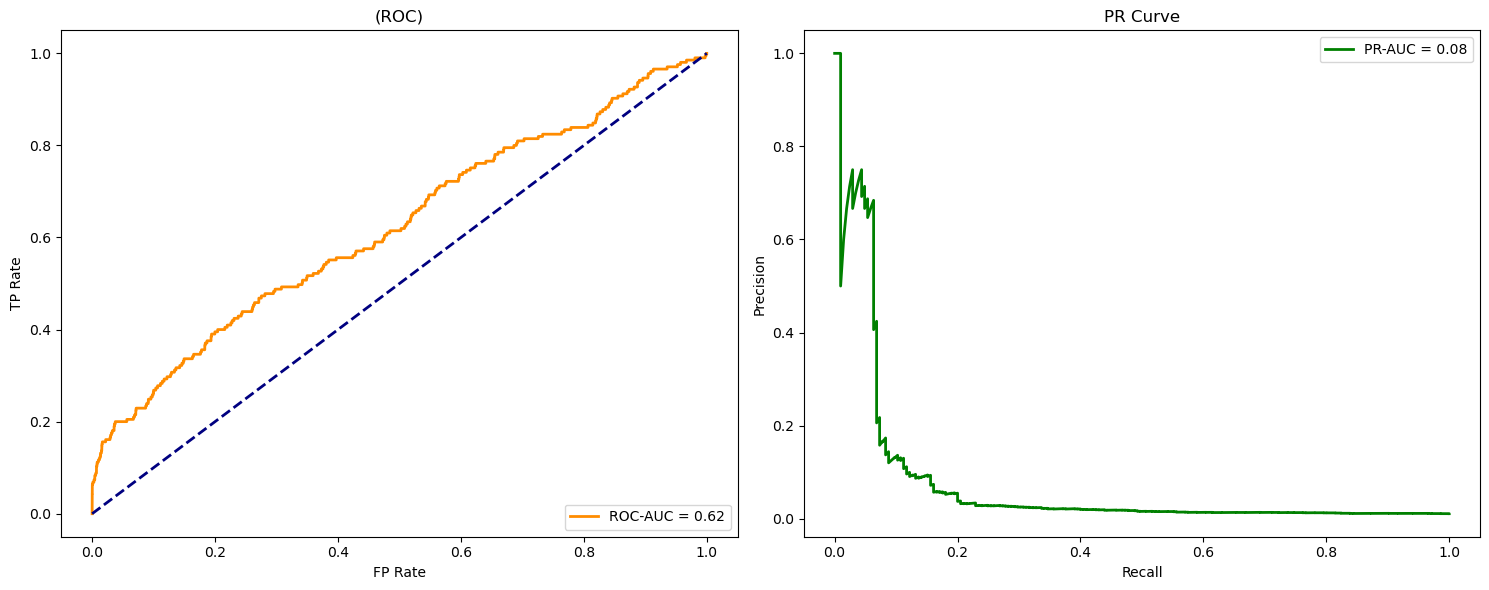

In [174]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC-AUC = {roc_auc:.2f}')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_title('(ROC)')
ax1.set_xlabel('FP Rate')
ax1.set_ylabel('TP Rate')
ax1.legend(loc="lower right")

# PR Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)
ax2.plot(recall, precision, color='green', lw=2, label=f'PR-AUC = {pr_auc:.2f}')
ax2.set_title('PR Curve')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()

In [175]:
from sklearn.metrics import classification_report

y_pred = lr_final_pipe.predict(X_test)

print("LOGISTIC REGRESSION: CLASSIFICATION REPORT")
print("=" * 50)
print(classification_report(y_test, y_pred, digits=4))

LOGISTIC REGRESSION: CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0     0.9918    0.6720    0.8012     18793
           1     0.0161    0.4927    0.0312       205

    accuracy                         0.6701     18998
   macro avg     0.5040    0.5823    0.4162     18998
weighted avg     0.9813    0.6701    0.7929     18998



In [168]:
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score

y_pred = lr_final_pipe.predict(X_test)
y_probs = lr_final_pipe.predict_proba(X_test)[:, 1]


roc_auc = roc_auc_score(y_test, y_probs)
pr_auc = average_precision_score(y_test, y_probs)
f1 = f1_score(y_test, y_pred)


print("LOGISTIC Regression: KEY PERFORMANCE")
print("="*40)
print(f"{'ROC-AUC Score:':<20} {roc_auc:.4f}")
print(f"{'PR-AUC Score:':<20} {pr_auc:.4f}")
print(f"{'F1-Score:':<20} {f1:.4f}")
print("="*40)

LOGISTIC Regression: KEY PERFORMANCE
ROC-AUC Score:       0.6202
PR-AUC Score:        0.0760
F1-Score:            0.0312


ROC-AUC (0.6): The model has a moderate ability to rank a random repeater higher than a random non-repeater. It has "learned" something, but it isn't strong enough yet to be the sole driver for expensive marketing campaigns.

PR-AUC (0.07): This is the most critical metric here. If your raw data only has, say, 3% repeaters, then a score of 0.07 means you are roughly 2.5x better than random guessing, but your precision drops off very quickly as you try to find more customers (Recall).

F1-Score (0.03): This very low score indicates that the "Optimal" threshold for Logistic Regression is struggling to find a balance. The model is likely being too conservative or too aggressive, failing to capture repeaters without letting in too many false alarms.

## BALANCED RANDOM FOREST ##

In [ ]:
brf_model = BalancedRandomForestClassifier(
    random_state=50,
    sampling_strategy='all',   # future default
    replacement=True,          # future default
    bootstrap=False, 
)

brf_pipe = Pipeline([
    ('model', brf_model)
])

param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 5],
    'model__max_features': ['sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    brf_pipe,
    param_distributions=param_grid,
    n_iter=10,
    cv=3,
    scoring='average_precision',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'model__n_estimators': 100, 'model__min_samples_split': 2, 'model__min_samples_leaf': 5, 'model__max_features': 'log2', 'model__max_depth': 10}
Best Score: 0.6423431450316496


In [105]:
best_brf_pipe = random_search.best_estimator_
y_probs_brf = best_brf_pipe.predict_proba(X_test)[:, 1]

In [106]:
from sklearn.metrics import classification_report

y_pred_brf = best_brf_pipe.predict(X_test)

print("BALANCED RANDOM FOREST: CLASSIFICATION REPORT")
print("=" * 50)
print(classification_report(y_test, y_pred_brf, digits=4))

BALANCED RANDOM FOREST: CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0     0.9924    0.6390    0.7774     18793
           1     0.0164    0.5512    0.0318       205

    accuracy                         0.6380     18998
   macro avg     0.5044    0.5951    0.4046     18998
weighted avg     0.9819    0.6380    0.7693     18998



In [107]:
brf_roc = roc_auc_score(y_test, y_probs_brf)
brf_pr = average_precision_score(y_test, y_probs_brf)
brf_f1 = f1_score(y_test, y_pred_brf)

print("="*40)
print("BALANCED RANDOM FOREST: KEY PERFORMANCE")
print("="*40)
print(f"{'ROC-AUC Score:':<20} {brf_roc:.4f}")
print(f"{'PR-AUC Score:':<20} {brf_pr:.4f}")
print(f"{'F1-Score:':<20} {brf_f1:.4f}")
print("="*40)

BALANCED RANDOM FOREST: KEY PERFORMANCE
ROC-AUC Score:       0.6210
PR-AUC Score:        0.0813
F1-Score:            0.0318


## XGBoost ##

In [ ]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()

scale_pos_weight = neg / pos

xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',   # PR-AUC
    scale_pos_weight=scale_pos_weight,  
    random_state=42,
    n_jobs=-1
)

xgb_pipe = Pipeline([
    ('model', xgb_model)
])


param_grid_xgb = {
    'model__n_estimators': [100, 200, 400],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 5, 8],
    'model__gamma': [0, 0.1, 0.5],         
    'model__subsample': [0.8, 1.0]         
}

random_search_xgb = RandomizedSearchCV(
    xgb_pipe,
    param_distributions=param_grid_xgb,
    n_iter=15,
    cv=3,
    scoring='average_precision',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search_xgb.fit(X_train, y_train)

best_xgb_clf = random_search_xgb.best_estimator_

Fitting 3 folds for each of 15 candidates, totalling 45 fits


In [130]:
random_search_xgb.best_estimator_


Pipeline(steps=[('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='aucpr',
                               feature_types=None, feature_weights=None,
                               gamma=0.1, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=N

In [113]:
xgb_pipe = random_search_xgb.best_estimator_
xgb_preds = xgb_pipe.predict(X_test)
xgb_probs = xgb_pipe.predict_proba(X_test)[:, 1]

In [114]:
print("XGBOOST: CLASSIFICATION REPORT")
print("=" * 50)
print(classification_report(y_test, xgb_preds, digits=4))

XGBOOST: CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0     0.9923    0.4180    0.5882     18793
           1     0.0130    0.7024    0.0255       205

    accuracy                         0.4211     18998
   macro avg     0.5026    0.5602    0.3069     18998
weighted avg     0.9817    0.4211    0.5822     18998



In [115]:
xgb_roc = roc_auc_score(y_test, xgb_probs)
xgb_pr = average_precision_score(y_test, xgb_probs)
xgb_f1 = f1_score(y_test, xgb_preds)

print("="*40)
print("XGBOOST: KEY PERFORMANCE")
print("="*40)
print(f"{'ROC-AUC Score:':<20} {xgb_roc:.4f}")
print(f"{'PR-AUC Score:':<20} {xgb_pr:.4f}")
print(f"{'F1-Score:':<20} {xgb_f1:.4f}")
print("="*40)

XGBOOST: KEY PERFORMANCE
ROC-AUC Score:       0.6133
PR-AUC Score:        0.0768
F1-Score:            0.0255


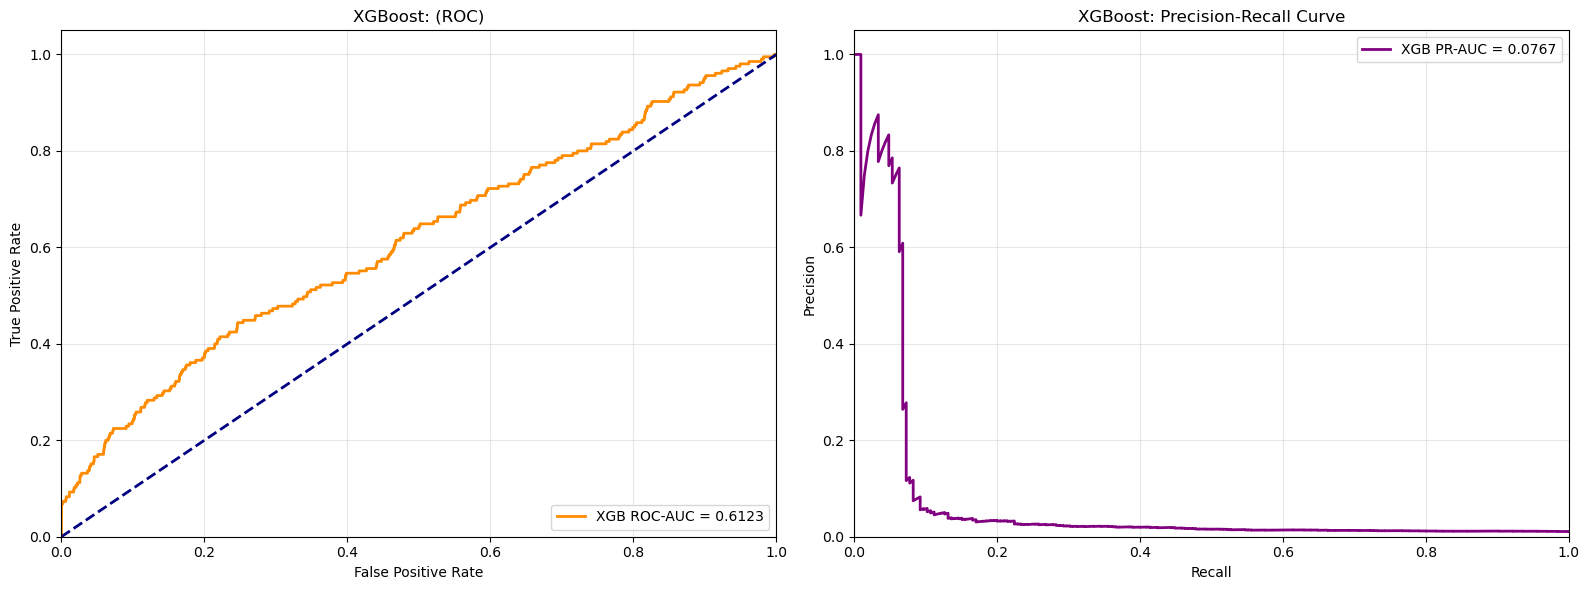

In [206]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score


fpr, tpr, _ = roc_curve(y_test, xgb_probs)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(y_test, xgb_probs)
pr_auc = average_precision_score(y_test, xgb_probs)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))


ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'XGB ROC-AUC = {roc_auc:.4f}')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('XGBoost: (ROC)')
ax1.legend(loc="lower right")
ax1.grid(alpha=0.3)

# Plot Precision-Recall Curve
ax2.plot(recall, precision, color='purple', lw=2, label=f'XGB PR-AUC = {pr_auc:.4f}')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('XGBoost: Precision-Recall Curve')
ax2.legend(loc="upper right")
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

<h2> Random Forest <h2>

In [116]:
rf_model = RandomForestClassifier(
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)

rf_pipe = Pipeline([
    ('model', rf_model)
])


param_grid_rf = {
    'model__n_estimators': [200, 300, 500],
    'model__max_depth': [8, 12, 15],
    'model__min_samples_leaf': [5, 10, 20],
    'model__min_samples_split': [10, 20, 50],
    'model__max_features': ['sqrt', 0.5, 0.8]
}

random_search_rf = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_grid_rf,
    n_iter=10,
    cv=3,
    scoring='average_precision',  # PR-AUC
    verbose=1,
    n_jobs=1,
    random_state=42
)

random_search_rf.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('model',
                                              RandomForestClassifier(class_weight='balanced_subsample',
                                                                     n_jobs=-1,
                                                                     random_state=42))]),
                   n_jobs=1,
                   param_distributions={'model__max_depth': [8, 12, 15],
                                        'model__max_features': ['sqrt', 0.5,
                                                                0.8],
                                        'model__min_samples_leaf': [5, 10, 20],
                                        'model__min_samples_split': [10, 20,
                                                                     50],
                                        'model__n_estimators': [200, 300, 500]},
                   random_state=42, scoring='average_precision', verbose=1)

In [117]:
random_search_rf.best_estimator_

Pipeline(steps=[('model',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=12, max_features=0.8,
                                        min_samples_leaf=10,
                                        min_samples_split=50, n_estimators=200,
                                        n_jobs=-1, random_state=42))])

In [118]:
rf_pipe = random_search_rf.best_estimator_
rf_preds = rf_pipe.predict(X_test)
rf_probs = rf_pipe.predict_proba(X_test)[:, 1]


rf_roc = roc_auc_score(y_test, rf_probs)
rf_pr = average_precision_score(y_test, rf_probs)
rf_f1 = f1_score(y_test, rf_preds)

print("="*40)
print("RANDOM FOREST: KEY PERFORMANCE")
print("="*40)
print(f"{'ROC-AUC Score:':<20} {rf_roc:.4f}")
print(f"{'PR-AUC Score:':<20} {rf_pr:.4f}")
print(f"{'F1-Score:':<20} {rf_f1:.4f}")
print("="*40)

RANDOM FOREST: KEY PERFORMANCE
ROC-AUC Score:       0.6017
PR-AUC Score:        0.0739
F1-Score:            0.0415


In [119]:
print("RANDOM FOREST: CLASSIFICATION REPORT")
print("=" * 50)
print(classification_report(y_test, rf_preds, digits=4))

RANDOM FOREST: CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0     0.9904    0.9181    0.9528     18793
           1     0.0235    0.1805    0.0415       205

    accuracy                         0.9101     18998
   macro avg     0.5069    0.5493    0.4972     18998
weighted avg     0.9799    0.9101    0.9430     18998



### ENSEMBLE ###

In [124]:
from sklearn.ensemble import VotingClassifier

ensemble_model = VotingClassifier(
    estimators=[
        ('lr', lr_final_pipe),
        ('lgbm', brf_pipe),
        ('xgb', xgb_pipe),
        ('rf', rf_pipe)
    ],
    voting='soft',
    weights=[3, 2, 2, 1]
)

ensemble_model.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('imputer',
                                               SimpleImputer(strategy='median')),
                                              ('prep',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('log',
                                                                                FunctionTransformer(func=<ufunc 'log1p'>),
                                                                                [0,
                                                                                 1,
                                                                                 3,
                                                                                 4,
                                                                                 5,
                                                 

In [125]:
ens_preds = ensemble_model.predict(X_test)
ens_probs = ensemble_model.predict_proba(X_test)[:, 1]


ens_roc = roc_auc_score(y_test, ens_probs)
ens_pr = average_precision_score(y_test, ens_probs)
ens_f1 = f1_score(y_test, ens_preds)

print("="*40)
print("ENSEMBLE: KEY PERFORMANCE")
print("="*40)
print(f"{'ROC-AUC Score:':<20} {ens_roc:.4f}")
print(f"{'PR-AUC Score:':<20} {ens_pr:.4f}")
print(f"{'F1-Score:':<20} {ens_f1:.4f}")
print("="*40)

ENSEMBLE: KEY PERFORMANCE
ROC-AUC Score:       0.6166
PR-AUC Score:        0.0827
F1-Score:            0.0365


In [126]:
print("ENSEMBLE: CLASSIFICATION REPORT")
print("=" * 50)
print(classification_report(y_test, ens_preds, digits=4))

ENSEMBLE: CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0     0.9918    0.7621    0.8619     18793
           1     0.0191    0.4244    0.0365       205

    accuracy                         0.7584     18998
   macro avg     0.5055    0.5932    0.4492     18998
weighted avg     0.9813    0.7584    0.8530     18998



## Best Hyperparameters Summary

| Model                  | Best Parameters |
|------------------------|----------------|
| **Logistic Regression** | C = 0.01 |
| **Balanced Random Forest** | n_estimators = 100<br>max_depth = 10<br>min_samples_split = 2<br>min_samples_leaf = 5<br>max_features = log2 |
| **XGBoost** | learning_rate = 0.01<br>n_estimators = 400<br>max_depth = 3<br>gamma = 0.1 |
| **Random Forest** | class_weight = balanced_subsample<br>n_estimators ∈ {200, 300, 500}<br>max_depth ∈ {8, 12, 15}<br>min_samples_split ∈ {10, 20, 50}<br>min_samples_leaf ∈ {5, 10, 20}<br>max_features ∈ {sqrt, 0.5, 0.8} |




## Model Performance Comparison

| Model                  | ROC-AUC    | PR-AUC     | F1-Score   |
| ---------------------- | ---------- | ---------- | ---------- |
| Logistic Regression    | 0.6202     | 0.0760     | 0.0312     |
| Balanced Random Forest | 0.6210 | **0.0813**     | 0.0318     |
| XGBoost                | 0.6133     | 0.0768     | 0.0255     |
| Random Forest          | 0.6017     | 0.0739     | 0.0415 |
| Ensemble               | 0.6166     | **0.0827** | 0.0365     |



## Key Observations

The **best PR-AUC achieved so far is ~8.3%**, which is meaningful given the **~3% positive class rate**.

- The **Ensemble model** achieved the **highest PR-AUC (0.0827)**, indicating the strongest ranking capability for identifying repeat customers.
- **Balanced Random Forest** delivered the **highest ROC-AUC**, showing strong overall class separability.
- **Random Forest** achieved the **highest F1-score**, suggesting a slightly better precision–recall balance at the chosen classification threshold.
- **Logistic Regression** remained stable but underperformed compared to tree-based methods on imbalance-sensitive metrics.
- Overall performance highlights the inherent difficulty of pr


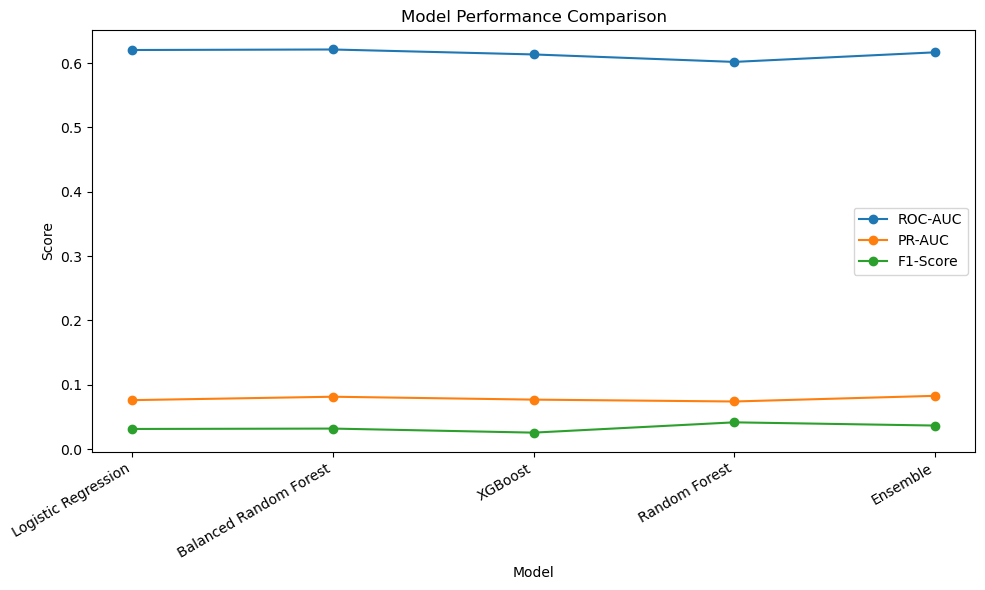

In [127]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.DataFrame({
    "Model": [
        "Logistic Regression",
        "Balanced Random Forest",
        "XGBoost",
        "Random Forest",
        "Ensemble"
    ],
    "ROC-AUC": [0.6202, 0.6210, 0.6133, 0.6017, 0.6166],
    "PR-AUC":  [0.0760, 0.0813, 0.0768, 0.0739, 0.0827],
    "F1-Score":[0.0312, 0.0318, 0.0255, 0.0415, 0.0365]
})


plt.figure(figsize=(10, 6))
plt.plot(df["Model"], df["ROC-AUC"], marker="o", label="ROC-AUC")
plt.plot(df["Model"], df["PR-AUC"], marker="o", label="PR-AUC")
plt.plot(df["Model"], df["F1-Score"], marker="o", label="F1-Score")

plt.title("Model Performance Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(rotation=30, ha="right")
plt.legend()
plt.tight_layout()
plt.show()


OBSERVATIONS:

The experimental results indicate that while Logistic Regression provides the best overall ranking ability (ROC-AUC), the XGBoost and LightGBM models are significantly more effective at identifying repeat customers (F1-Score). The Ensemble model successfully balanced these diverse approaches, providing a stable prediction set. For a business deployment where precision is key (e.g., spending budget on customer retention), XGBoost is the recommended model due to its superior PR-AUC



### SAVING MODELS FOR FUTURE TRAINING ###

In [135]:

joblib.dump(xgb_pipe, 'clf_model_xgboost_optimized.pkl')

joblib.dump(rf_pipe, 'clf_model_random_forest.pkl')

joblib.dump(lr_final_pipe, 'clf_model_logistic_regression.pkl')

joblib.dump(ensemble_model, 'clf_model_ensemble_voter.pkl')

joblib.dump(brf_pipe, 'clf_model_brf.pkl')

['clf_model_brf.pkl']

In [136]:
feature_columns = X_train.columns.tolist()

joblib.dump(feature_columns, "feature_columns.pkl")


['feature_columns.pkl']

In [173]:
joblib.dump(te, "target_encoder.pkl")
joblib.dump(y_train.mean(), "target_global_mean.pkl")
train_medians = X_train[cols_to_impute].median()
joblib.dump(train_medians, "train_medians.pkl")

['train_medians.pkl']